**MobileNet model.**

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Paths
image_dir = '/kaggle/input/final-data/all_data'         # folder with all images
csv_path = '/kaggle/input/data-after-spilt/labeled_images.csv'      # CSV file with image labels

# Load CSV
df = pd.read_csv(csv_path)

# Optional: preview
print(df.head())


         image_name  score  label
0  15_inv_to256x512     32      3
1  25_inv_to256x512     32      3
2  35_inv_to256x512     29      3
3  45_inv_to256x512     29      3
4  55_inv_to256x512     25      2


In [4]:
# List all files in the image directory
available_files = set(os.listdir(image_dir))

# Define helper to find full filename
def find_full_filename(base_name):
    for ext in ['.jpg', '.png', '.JPG', '.jpeg']:
        full_name = base_name + ext
        if full_name in available_files:
            return full_name
    return None

# Add full filenames to a new column used by flow_from_dataframe
df['image_name'] = df['image_name'].apply(find_full_filename)

# Drop any rows where the image wasn't found
df = df.dropna(subset=['image_name'])


In [5]:
# Split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Split temp into val and test (50% each of 20% -> 10%/10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


In [6]:
# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

# No augmentation for val/test
test_val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
target_size = (224, 224)
batch_size = 32
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=target_size,
    color_mode='grayscale',           
    class_mode='categorical',
    batch_size=batch_size
)

# Validation data generator
val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=target_size,
    color_mode='grayscale',          
    class_mode='categorical',
    batch_size=batch_size
)

# Test data generator
test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=target_size,
    color_mode='grayscale',          
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 1453 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [9]:
# Input shape as per the paper (but images are grayscale, so we adapt accordingly)
# MobileNet requires 3 channels, so we replicate grayscale input to 3 channels using a Lambda layer

input_shape = (224, 224, 1)  # Original input shape
target_input_shape = (224, 224, 3)  # Required by MobileNet

# Input layer
inputs = Input(shape=input_shape)

# Convert 1 channel to 3 channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Load MobileNet base with pre-trained ImageNet weights
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=target_input_shape
)

# Freeze base model (do not train)
base_model.trainable = False

# Add base model to the pipeline
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs, outputs)

# Summary
model.summary()


I0000 00:00:1753026518.830803      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 3)                │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ concatenate[0][0] │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    524,800 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      2,052 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,755,716 (14.33 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [10]:
# Compile using Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
# Train for 30 epochs, batch size = 32 (as defined)
epochs = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=32  # note: batch size is controlled by the generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1753026530.167276      99 service.cc:148] XLA service 0x7dda5c002190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753026530.168300      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753026530.734446      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/46 ━━━━━━━━━━━━━━━━━━━━ 5:45 8s/step - accuracy: 0.1562 - loss: 1.7083

I0000 00:00:1753026533.469726      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.6618 - loss: 1.0657 - val_accuracy: 0.7857 - val_loss: 0.7490
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7962 - loss: 0.5758 - val_accuracy: 0.7912 - val_loss: 0.6063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.8277 - loss: 0.5096 - val_accuracy: 0.7802 - val_loss: 0.6276
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8301 - loss: 0.4371 - val_accuracy: 0.8022 - val_loss: 0.6227
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.8108 - loss: 0.4815 - val_accuracy: 0.7692 - val_loss: 0.6527
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.8434 - loss: 0.4236 - val_accuracy: 0.8132 - val_loss: 0.6394
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8479 - loss: 0.3989 - val_accuracy: 0.7637 - val_loss: 0.6829
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8788 - loss: 0.3181 - val_accuracy: 0.7912 - val

In [12]:
# Set test_generator batch size to 1 for evaluation, no shuffle
test_generator.batch_size = 1
test_generator.shuffle = False

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7999 - loss: 0.7726
Test Accuracy: 0.7582


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Predict
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.11      0.04      0.06        25
           2       0.80      0.96      0.87       136
           3       0.00      0.00      0.00         6

    accuracy                           0.76       182
   macro avg       0.40      0.37      0.37       182
weighted avg       0.67      0.76      0.71       182



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


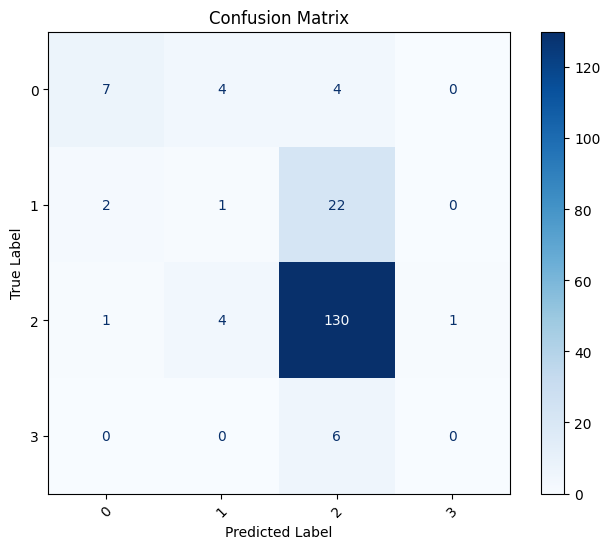

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')  
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.show()


**MobileNet-V2 model**

In [20]:
from tensorflow.keras.applications import MobileNetV2


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,               
    rotation_range=20,           
    width_shift_range=0.1,        
    height_shift_range=0.1,       
    shear_range=0.1,              
    zoom_range=0.2,               
    horizontal_flip=True,         
    fill_mode='nearest'           
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='image_name',           
    y_col='label',
    target_size=target_size,      
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,                 
    color_mode='rgb'             
)

val_generator = test_val_datagen.flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=target_size,      
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,                 
    color_mode='rgb'             
)


test_generator = test_val_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=target_size,
    class_mode='categorical',
    batch_size=1,                
    shuffle=False,                
    color_mode='rgb'              
)


Found 1453 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.


In [ ]:
num_classes = len(train_generator.class_indices)  
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
epochs = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 560ms/step - accuracy: 0.6472 - loss: 1.4976 - val_accuracy: 0.7527 - val_loss: 0.7166
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.7827 - loss: 0.6423 - val_accuracy: 0.7692 - val_loss: 0.6794
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - accuracy: 0.8073 - loss: 0.5468 - val_accuracy: 0.7802 - val_loss: 0.6682
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.8003 - loss: 0.5458 - val_accuracy: 0.7582 - val_loss: 0.6747
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.8151 - loss: 0.5245 - val_accuracy: 0.7582 - val_loss: 0.7434
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 380ms/step - accuracy: 0.8353 - loss: 0.4633 - val_accuracy: 0.7967 - val_loss: 0.7432
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 379ms/step - accuracy: 0.8364 - loss: 0.4597 - val_accuracy: 0.7802 - val_loss: 0.6274
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.8434 - loss: 0.4352 - val_accu

In [27]:
# Set test_generator batch size to 1 for evaluation, no shuffle
test_generator.batch_size = 1
test_generator.shuffle = False

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8097 - loss: 0.6756
Test Accuracy: 0.7637


182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
📊 Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.25      0.08      0.12        25
           2       0.81      0.95      0.87       136
           3       0.25      0.17      0.20         6

    accuracy                           0.76       182
   macro avg       0.49      0.42      0.43       182
weighted avg       0.70      0.76      0.72       182



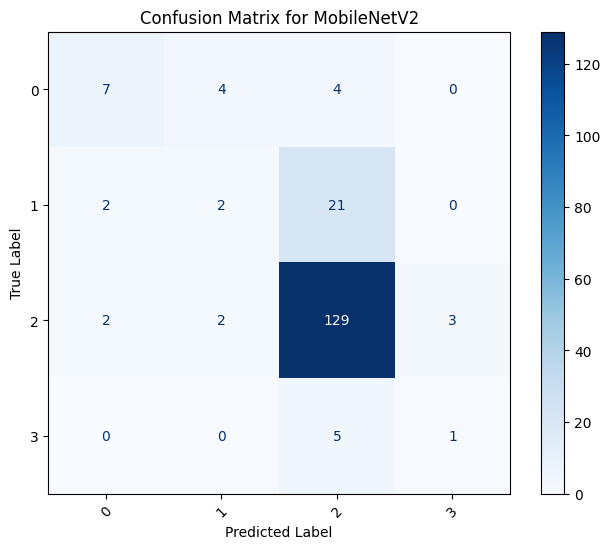

In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix for MobileNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# (Accuracy)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#(Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save('mobilenet_model_0.7582.h5')

model.save('mobilenetv2_model_0.7637.h5')


**Xception model**

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


num_classes = len(train_generator.class_indices)  

base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,912,620 (83.59 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
epochs = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 592ms/step - accuracy: 0.7197 - loss: 0.8823 - val_accuracy: 0.7143 - val_loss: 0.7738
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.7708 - loss: 0.6576 - val_accuracy: 0.7473 - val_loss: 0.7331
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - accuracy: 0.7988 - loss: 0.5820 - val_accuracy: 0.7418 - val_loss: 0.7298
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 396ms/step - accuracy: 0.7924 - loss: 0.5601 - val_accuracy: 0.7637 - val_loss: 0.7341
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.7992 - loss: 0.5357 - val_accuracy: 0.7363 - val_loss: 0.7636
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.8198 - loss: 0.4943 - val_accuracy: 0.7527 - val_loss: 0.7080
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.8176 - loss: 0.4872 - val_accuracy: 0.7527 - val_loss: 0.7614
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.8344 - loss: 0.4445 - val_accu

In [ ]:
model.save('xception_model 0.7308.h5') 


In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


In [34]:
from sklearn.metrics import classification_report

print("📊 Classification Report (Xception):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))


📊 Classification Report (Xception):

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        15
           1       0.30      0.12      0.17        25
           2       0.82      0.86      0.84       136
           3       0.25      0.33      0.29         6

    accuracy                           0.73       182
   macro avg       0.47      0.51      0.47       182
weighted avg       0.71      0.73      0.71       182



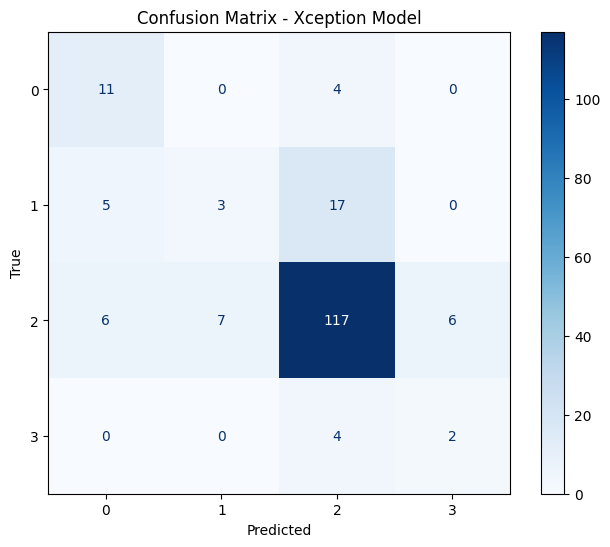

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Xception Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [37]:
# Set test_generator batch size to 1 for evaluation, no shuffle
test_generator.batch_size = 1
test_generator.shuffle = False

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7349 - loss: 0.7707
Test Accuracy: 0.7308


**Inception-V3 model**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)

base_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
outputs = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [42]:
epochs = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 764ms/step - accuracy: 0.6934 - loss: 1.6259 - val_accuracy: 0.7857 - val_loss: 0.7522
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - accuracy: 0.7790 - loss: 0.6389 - val_accuracy: 0.7692 - val_loss: 0.7584
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 401ms/step - accuracy: 0.7877 - loss: 0.6053 - val_accuracy: 0.7308 - val_loss: 0.7816
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 401ms/step - accuracy: 0.7787 - loss: 0.6108 - val_accuracy: 0.7527 - val_loss: 0.7443
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.8005 - loss: 0.5772 - val_accuracy: 0.7637 - val_loss: 0.7624
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.7917 - loss: 0.5894 - val_accuracy: 0.7088 - val_loss: 0.7445
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.7819 - loss: 0.5751 - val_accuracy: 0.6538 - val_loss: 0.8128
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.7964 - loss: 0.5624 - val_accu

In [43]:
# Set test_generator batch size to 1 for evaluation, no shuffle
test_generator.batch_size = 1
test_generator.shuffle = False

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8424 - loss: 0.5008
Test Accuracy: 0.8022


In [44]:
model.save('inceptionv3_model0.8022.h5')


182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
📊 Classification Report (InceptionV3):

              precision    recall  f1-score   support

           0       0.83      0.33      0.48        15
           1       0.45      0.20      0.28        25
           2       0.82      1.00      0.90       136
           3       0.00      0.00      0.00         6

    accuracy                           0.80       182
   macro avg       0.53      0.38      0.41       182
weighted avg       0.75      0.80      0.75       182



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


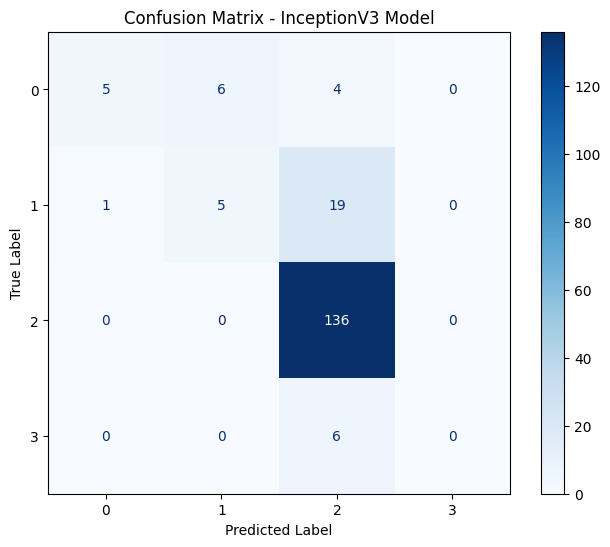

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("📊 Classification Report (InceptionV3):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - InceptionV3 Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
